# Multi-Station Supervised models

## General Imports

In [1]:
import os
import pandas as pd
from sklearn.ensemble import ExtraTreesRegressor
from sklearn import linear_model
from sklearn.dummy import DummyRegressor
import altair as alt
from sklearn.model_selection import cross_val_score
from skopt.space import Integer
from skopt.utils import use_named_args
import numpy as np
from skopt import gp_minimize
from skopt.plots import plot_convergence
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## Small dataset (2022 only) 
### Get cleaned data from pickle file 

In [2]:
ROOT_DIR = os.path.realpath(os.path.join(os.getcwd(), '..'))
# cln_pkl_loc = os.path.join(ROOT_DIR, 'data_cleaning','cleanweathersmall.pkl')
cln_pkl_loc = os.path.join(ROOT_DIR, 'data','cleanweathersmall.pkl')

In [3]:
df = pd.read_pickle(cln_pkl_loc)
df

,station,time,temp,dwpt,rhum,prcp,wdir,wspd,pres
0,0CNUO,2022-01-01 00:00:00,-25.1,-28.1,76.0,0.0,271.0,12.6,1020.8
1,0CNUO,2022-01-01 01:00:00,-25.7,-28.7,76.0,0.0,275.0,13.0,1021.5
2,0CNUO,2022-01-01 02:00:00,-26.2,-29.3,75.0,0.0,273.0,12.6,1022.5
3,0CNUO,2022-01-01 03:00:00,-26.1,-29.1,76.0,0.0,277.0,13.7,1022.6
4,0CNUO,2022-01-01 04:00:00,-26.5,-29.6,75.0,0.0,275.0,13.3,1023.2
...,...,...,...,...,...,...,...,...,...
3656995,ZWC6W,2022-09-22 19:00:00,7.3,0.7,63.0,0.0,330.0,23.0,1017.8
3656996,ZWC6W,2022-09-22 20:00:00,8.1,0.8,60.0,0.0,340.0,29.0,1017.9
3656997,ZWC6W,2022-09-22 21:00:00,7.8,1.4,64.0,0.0,320.0,21.0,1018.1
3656998,ZWC6W,2022-09-22 22:00:00,8.6,2.2,64.0,0.0,320.0,18.0,1018.4


### Basic data cleaning to build necessary features

In [4]:
pivoted_df = df.pivot(index='time', columns='station', values=['temp', 'dwpt','rhum','prcp','wdir','wspd','pres'])
pivoted_df.columns = ['_'.join(col) for col in pivoted_df.columns.values]
pivoted_df

,temp_0CNUO,temp_0CO7B,temp_0FV1F,temp_1J1PJ,temp_1JWST,temp_20QWH,temp_21O3U,temp_2W8UZ,temp_3S56J,temp_4DUJO,...,pres_O879F,pres_QHA0T,pres_SJZBK,pres_UJHR7,pres_UV7W2,pres_V5792,pres_VMWBN,pres_XM44W,pres_ZFZUV,pres_ZWC6W
time,,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:00:00,-25.1,5.0,1.2,-0.9,-6.5,-28.7,-29.0,4.6,-26.5,1.8,...,1009.4,1013.2,1025.5,1021.0,1023.8,1019.9,1022.6,1013.5,1023.8,1010.8
2022-01-01 01:00:00,-25.7,5.1,0.9,-0.6,-7.5,-29.5,-28.9,4.6,-27.3,1.6,...,1009.0,1014.2,1026.0,1022.3,1024.5,1020.8,1023.4,1014.6,1024.2,1011.8
2022-01-01 02:00:00,-26.2,4.2,1.5,-0.8,-8.6,-30.2,-30.1,4.7,-27.9,0.9,...,1007.4,1014.5,1026.3,1023.0,1024.9,1021.2,1024.0,1015.1,1024.9,1012.7
2022-01-01 03:00:00,-26.1,5.5,4.1,-0.9,-9.4,-29.9,-30.1,4.6,-28.1,1.0,...,1007.2,1015.3,1026.3,1023.9,1025.2,1022.1,1024.5,1016.0,1025.4,1013.6
2022-01-01 04:00:00,-26.5,5.9,3.1,-1.2,-10.1,-30.4,-31.4,4.9,-28.6,0.5,...,1006.6,1016.1,1026.4,1024.4,1025.2,1022.9,1024.8,1017.3,1025.4,1013.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-22 19:00:00,12.4,17.8,13.7,11.5,10.2,13.5,12.5,15.2,10.8,12.4,...,1014.3,1022.6,1023.0,1025.5,1024.7,1024.6,1025.0,1022.6,1024.5,1017.8
2022-09-22 20:00:00,13.0,17.0,14.3,12.0,10.4,14.0,12.5,14.8,11.4,11.6,...,1014.5,1022.4,1021.5,1024.8,1023.5,1023.8,1023.7,1022.4,1023.1,1017.9
2022-09-22 21:00:00,13.2,16.6,13.9,12.4,10.5,14.3,12.4,15.1,11.7,10.8,...,1014.9,1022.2,1020.6,1023.9,1022.9,1023.7,1023.1,1022.2,1022.0,1018.1


In [5]:
pivoted_df[pivoted_df.index > '2022-09']

,temp_0CNUO,temp_0CO7B,temp_0FV1F,temp_1J1PJ,temp_1JWST,temp_20QWH,temp_21O3U,temp_2W8UZ,temp_3S56J,temp_4DUJO,...,pres_O879F,pres_QHA0T,pres_SJZBK,pres_UJHR7,pres_UV7W2,pres_V5792,pres_VMWBN,pres_XM44W,pres_ZFZUV,pres_ZWC6W
time,,,,,,,,,,,,,,,,,,,,,
2022-09-01 01:00:00,19.7,23.9,21.5,13.7,10.7,22.0,21.7,21.1,19.2,17.2,...,1010.0,1010.9,1011.3,1011.1,1011.0,1012.0,1010.6,1011.8,1009.9,1009.7
2022-09-01 02:00:00,18.8,23.3,20.7,13.3,8.0,20.9,20.6,19.9,18.1,16.0,...,1011.2,1011.5,1011.6,1011.2,1011.1,1012.1,1010.9,1012.6,1010.1,1009.7
2022-09-01 03:00:00,16.9,22.7,19.4,13.2,6.2,20.3,21.2,20.0,17.1,15.2,...,1011.7,1011.9,1011.4,1011.2,1011.1,1012.1,1010.8,1013.0,1010.0,1009.8
2022-09-01 04:00:00,16.7,21.5,18.0,12.2,5.3,20.0,21.9,18.9,16.0,14.3,...,1012.0,1012.2,1011.2,1010.9,1011.1,1012.3,1010.8,1013.4,1010.0,1010.1
2022-09-01 05:00:00,16.9,20.6,16.5,11.8,4.4,20.0,20.9,18.7,15.3,13.3,...,1013.1,1012.4,1011.1,1010.6,1010.8,1012.1,1010.5,1013.9,1009.4,1010.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-22 19:00:00,12.4,17.8,13.7,11.5,10.2,13.5,12.5,15.2,10.8,12.4,...,1014.3,1022.6,1023.0,1025.5,1024.7,1024.6,1025.0,1022.6,1024.5,1017.8
2022-09-22 20:00:00,13.0,17.0,14.3,12.0,10.4,14.0,12.5,14.8,11.4,11.6,...,1014.5,1022.4,1021.5,1024.8,1023.5,1023.8,1023.7,1022.4,1023.1,1017.9
2022-09-22 21:00:00,13.2,16.6,13.9,12.4,10.5,14.3,12.4,15.1,11.7,10.8,...,1014.9,1022.2,1020.6,1023.9,1022.9,1023.7,1023.1,1022.2,1022.0,1018.1


### Our target is Ann Arbor which is station __"KARB0"__, so pulling those features out. And we want to predict the weather 24 hours in the future, so need to duplicate and shift the features while doing some more basic cleaning 

In [6]:
ann_arbor_cols = [col for col in pivoted_df.columns if "KARB0" in col]
ann_arbor_df = pivoted_df[ann_arbor_cols].copy()
for col in ann_arbor_df.columns:
    ann_arbor_df[f'24 hr~{col}'] = ann_arbor_df[col].shift(-24)
ann_arbor_df = ann_arbor_df.rename_axis(None, axis = 0)
ann_arbor_df.head(5)

,temp_KARB0,dwpt_KARB0,rhum_KARB0,prcp_KARB0,wdir_KARB0,wspd_KARB0,pres_KARB0,24 hr~temp_KARB0,24 hr~dwpt_KARB0,24 hr~rhum_KARB0,24 hr~prcp_KARB0,24 hr~wdir_KARB0,24 hr~wspd_KARB0,24 hr~pres_KARB0
2022-01-01 00:00:00,5.0,2.9,86.0,0.0,120.0,11.0,1005.0,-2.2,-3.9,88.0,0.6,50.0,16.6,1010.0
2022-01-01 01:00:00,5.0,2.9,86.0,0.0,120.0,11.2,1005.4,-2.8,-5.6,81.0,0.7,30.0,16.6,1010.2
2022-01-01 02:00:00,5.0,2.9,86.0,0.0,120.0,5.4,1005.3,-3.3,-5.6,84.0,0.4,30.0,24.1,1009.9
2022-01-01 03:00:00,5.0,2.9,86.0,0.0,0.0,0.0,1004.9,-3.9,-6.1,85.0,0.3,20.0,18.4,1010.3
2022-01-01 04:00:00,5.6,3.3,85.0,0.0,0.0,0.0,1004.9,-4.4,-6.1,88.0,0.3,30.0,16.6,1010.1


### We need to merge the new features with the main dataframe so we have not only the Ann Arbor measurements, but also all measurements from surrounding stations.

In [7]:
pred_df = pd.merge(pivoted_df,ann_arbor_df, left_index=True, right_index=True)
pred_df = pred_df[pred_df['24 hr~temp_KARB0'].notna()]
print(pred_df.shape)


(6336, 4039)


In [8]:
pred_df[pred_df.index > '2022-09']

,temp_0CNUO,temp_0CO7B,temp_0FV1F,temp_1J1PJ,temp_1JWST,temp_20QWH,temp_21O3U,temp_2W8UZ,temp_3S56J,temp_4DUJO,...,wdir_KARB0_y,wspd_KARB0_y,pres_KARB0_y,24 hr~temp_KARB0,24 hr~dwpt_KARB0,24 hr~rhum_KARB0,24 hr~prcp_KARB0,24 hr~wdir_KARB0,24 hr~wspd_KARB0,24 hr~pres_KARB0
time,,,,,,,,,,,,,,,,,,,,,
2022-09-01 01:00:00,19.7,23.9,21.5,13.7,10.7,22.0,21.7,21.1,19.2,17.2,...,280.0,11.2,1013.7,18.9,15.6,81.0,0.0,190.0,5.4,1017.2
2022-09-01 02:00:00,18.8,23.3,20.7,13.3,8.0,20.9,20.6,19.9,18.1,16.0,...,280.0,11.2,1014.1,17.2,15.0,87.0,0.0,0.0,0.0,1017.6
2022-09-01 03:00:00,16.9,22.7,19.4,13.2,6.2,20.3,21.2,20.0,17.1,15.2,...,270.0,9.4,1014.3,16.7,15.1,90.0,0.0,0.0,0.0,1018.0
2022-09-01 04:00:00,16.7,21.5,18.0,12.2,5.3,20.0,21.9,18.9,16.0,14.3,...,260.0,9.4,1014.2,14.4,13.3,93.0,0.0,0.0,0.0,1018.1
2022-09-01 05:00:00,16.9,20.6,16.5,11.8,4.4,20.0,20.9,18.7,15.3,13.3,...,250.0,11.2,1014.4,14.4,13.3,93.0,0.0,0.0,0.0,1018.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-21 19:00:00,10.6,28.6,26.2,20.6,14.8,12.5,13.4,25.1,10.1,24.9,...,290.0,22.3,1007.3,15.0,3.5,46.0,0.0,320.0,25.9,1017.6
2022-09-21 20:00:00,10.7,29.1,25.9,20.2,13.4,12.5,13.9,28.6,10.8,26.0,...,260.0,18.4,1007.0,16.1,4.5,46.0,0.0,320.0,18.4,1017.9
2022-09-21 21:00:00,10.9,30.2,23.9,19.1,13.2,12.0,14.5,28.2,11.5,24.6,...,280.0,18.4,1007.4,16.0,4.4,46.0,0.0,330.0,22.0,1019.0


~~### There are a lot of features with excessive amounts of null values to get rid of. Dropping any with more than 500 missing values still leaves a sufficient number of features for predicting~~
### Correction
Used interpolation in cleaning model to fill na, no longer need this cell

In [9]:
# to_drop = []
# for col in pred_df.columns:
#     num = pred_df[col].isna().sum()
#     if num > 500:
#         # print(f"{col} has {num} missing values")
#         to_drop.append(col)
# pred_df.drop(columns=to_drop,inplace=True)
# # pred_df.dropna(inplace=True)

# for i in pred_df.columns[pred_df.isnull().any(axis=0)]:     #---Applying Only on variables with NaN values
#     pred_df[i].fillna(pred_df[i].mean(),inplace=True)
# pred_df.shape


### Now our target will be the '-24hr~temp_KARB0' column, and our features to use in our first prediction model will be all of the measurements at every surrounding station 24 hours prior to our target.
This cell will run 5 fold cross-validate on our 3 chosen regression models (Extra Trees Regressor, Lasso Regressor, and Tweedie Regressor). This will show how the average accuracy scores compare across these models on this data set.

In [10]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
X_cols = [col for col in pred_df.columns if "~" not in col]
X = pred_df[X_cols]
y = pred_df['24 hr~temp_KARB0']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=696)
xt_reg = ExtraTreesRegressor(random_state=696,n_jobs=-1)
lasso_reg = linear_model.Lasso(alpha=0.1,max_iter=1500)
tw_reg = linear_model.TweedieRegressor(max_iter=250)
dummy_reg = DummyRegressor(strategy="median")
models = {'Extra Trees Regressor':xt_reg,
          'Lasso Regressor':lasso_reg,
          'Tweedie Regressor':tw_reg,
          'Dummy Regressor':dummy_reg}
for key, value in models.items():
    # value = make_pipeline(StandardScaler(), value)
#     cv_results = cross_validate(value, X_train, y_train, cv=5,n_jobs=-1)
    print(key)
#     print("Mean accuracy score: ", end="")
#     print(round(cv_results['test_score'].mean(),3), end="")
#     print(", best accuracy score: ", end="")
#     print(round(cv_results['test_score'].max(),3), end="")
#     print(", with std dev of: ", end="")
#     print(round(cv_results['test_score'].std(),3))
#     print("Mean training time: ", end="")
#     print(round(cv_results['score_time'].mean(),3))
#     print(f"Score on hold out set: {round(value.fit(X_train, y_train).score(X_test, y_test),3)}")
    print(f"Score on time sensitive hold out set: {round(value.fit(X[:-503], y[:-503]).score(X[-503:], y[-503:]),3)}")
    print("**************")

Extra Trees Regressor
Score on time sensitive hold out set: 0.688
**************
Lasso Regressor


c:\users\jesse\onedrive\documents\homework\mich\521\ms2_git\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(


Score on time sensitive hold out set: 0.611
**************
Tweedie Regressor
Score on time sensitive hold out set: 0.611
**************
Dummy Regressor
Score on time sensitive hold out set: -2.166
**************


c:\users\jesse\onedrive\documents\homework\mich\521\ms2_git\lib\site-packages\sklearn\linear_model\_glm\glm.py:294: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


### Examine the feature importances in the best performing model (Extra Trees Regressor)

In [11]:
feature_importance_df = pd.DataFrame([X.columns, xt_reg.feature_importances_]).transpose()
feature_importance_df.columns = ['Feature', 'Importance']
feature_importance_df.sort_values('Importance',ascending=False,inplace=True)
feature_importance_df.to_csv("small_basic_features.csv",index=False)
feature_importance_df.head(10)

,Feature,Importance
405,temp_KMFI0,0.044344
371,temp_KISW0,0.043474
142,temp_72741,0.038861
521,temp_KTOB0,0.038339
385,temp_KLNL0,0.037256
271,temp_KD250,0.03617
208,temp_KARV0,0.035947
315,temp_KFKA0,0.031594
486,temp_KRHI0,0.030531
269,temp_KCWA0,0.029631


In [12]:

alt.Chart(feature_importance_df[:5]).mark_bar().encode(
    x=alt.X('Importance:Q', axis=alt.Axis(format="%", tickSize=0, labelFontSize=12)),
    y=alt.Y(
        'Feature:N', sort=list(feature_importance_df[:5].Feature), title="",
        axis=alt.Axis(tickSize=0, labelFontSize=12, labelPadding=10)),
).properties(
    height=200
)

alt.Chart(...)

### Hyper-parameter tuning the Extra Trees Regressor
5 fold cross validate looking for the optimized estimators, depth, sample split, and sample leaf parameters. Evaluating the 'best' based on the mean squared error achieved.

In [13]:
# %%timeit -r 1 -n 1
space  = [Integer(100,200, name='n_estimators'),
          Integer(1, 50, name='max_depth'),
          Integer(2, 100, name='min_samples_split'),
          Integer(1, 100, name='min_samples_leaf')]

@use_named_args(space)
def objective(**params):
    xt_reg.set_params(**params)

#     return -np.mean(cross_val_score(xt_reg, X_train, y_train, cv=5, n_jobs=-1))
    return -np.mean(value.fit(X[:-503], y[:-503]).score(X[-503:], y[-503:]))

res_gp = gp_minimize(objective, space, n_calls=15, random_state=696)

print(f"Best score: {res_gp.fun}")
print("Best parameters:")
print(f" - n-estimators= {res_gp.x[0]}")
print(f" - max_depth= {res_gp.x[1]}")
print(f" - min_samples_split= {res_gp.x[2]}")
print(f" - min_samples_leaf=  {res_gp.x[3]}")

Best score: 2.1663392254098444
Best parameters:
 - n-estimators= 124
 - max_depth= 2
 - min_samples_split= 28
 - min_samples_leaf=  91


### Visualize the convergence for the above hypertuning

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

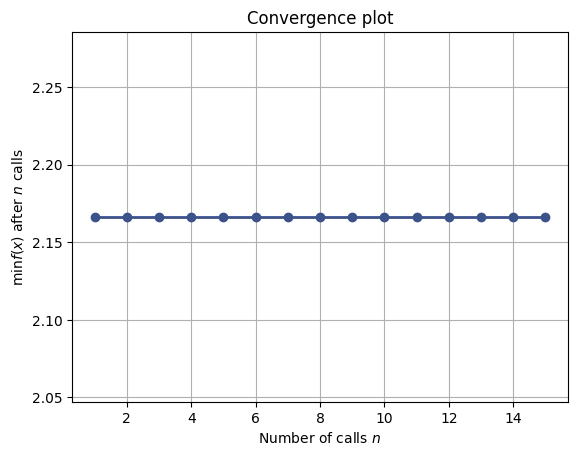

In [14]:
plot_convergence(res_gp)

### Final re-run of the Extra Trees Model with the tuned hyperparameters
There is a very minor improvement on the accuracy score, with some pretty significant increases in training time.

In [15]:
xt_reg = ExtraTreesRegressor(n_estimators=res_gp.x[0], 
                             max_depth=res_gp.x[1], 
                             min_samples_split=res_gp.x[2], 
                             min_samples_leaf=res_gp.x[3], 
                             random_state=696,n_jobs=-1
                            )
models = {'Extra Trees Regressor':xt_reg}
for key, value in models.items():
#     cv_results = cross_validate(value, X_train, y_train, cv=5,n_jobs=-1)
    print(key)
#     print("Mean accuracy score: ", end="")
#     print(round(cv_results['test_score'].mean(),3), end="")
#     print(", best accuracy score: ", end="")
#     print(round(cv_results['test_score'].max(),3), end="")
#     print(", with std dev of: ", end="")
#     print(round(cv_results['test_score'].std(),3))
#     print("Mean training time: ", end="")
#     print(round(cv_results['score_time'].mean(),3))
#     print(f"Score on hold out set: {round(value.fit(X_train, y_train).score(X_test, y_test),3)}")
    print(f"Score on time sensitive hold out set: {round(value.fit(X[:-503], y[:-503]).score(X[-503:], y[-503:]),3)}")
    print("**************")

Extra Trees Regressor
Score on time sensitive hold out set: 0.559
**************


In [16]:
final_df = pd.DataFrame()
final_df['Actual'] = y.values
final_df['XT-pred'] = xt_reg.predict(X)
final_df['Lo-pred'] = lasso_reg.predict(X)
final_df['Tw-pred'] = tw_reg.predict(X)
final_df['Dum-pred'] = dummy_reg.predict(X)
final_df['TimeStamp'] = pred_df.index
# final_df = final_df.melt(id_vars='TimeStamp')
final_df.to_csv('small_basic_predictions.csv', index=False)

## Full US dataset (2019-Sept 2022)
### Get cleaned data from pickle file

In [17]:
ROOT_DIR = os.path.realpath(os.path.join(os.getcwd(), '..'))
cln_pkl_loc = os.path.join(ROOT_DIR, 'data_cleaning','cleanweather.pkl')

In [18]:
df = pd.read_pickle(cln_pkl_loc)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62183652 entries, 0 to 62183651
Data columns (total 9 columns):
 #   Column   Dtype         
---  ------   -----         
 0   station  object        
 1   time     datetime64[ns]
 2   temp     float64       
 3   dwpt     float64       
 4   rhum     float64       
 5   prcp     float64       
 6   wdir     float64       
 7   wspd     float64       
 8   pres     float64       
dtypes: datetime64[ns](1), float64(7), object(1)
memory usage: 4.2+ GB


### Basic data cleaning to build necessary features

In [19]:
pivoted_df = df.pivot(index='time', columns='station', values=['temp', 'dwpt','rhum','prcp','wdir','wspd','pres'])
pivoted_df.columns = ['_'.join(col) for col in pivoted_df.columns.values]
pivoted_df

,temp_04AEH,temp_0CC8G,temp_0CNUO,temp_0CO7B,temp_0FV1F,temp_0FV2W,temp_0JM7R,temp_0JPFS,temp_0NNEW,temp_0RJDR,...,pres_Z8Y0M,pres_ZFS01,pres_ZFZUV,pres_ZJ8AR,pres_ZNWZW,pres_ZRBBD,pres_ZUQJS,pres_ZWC6W,pres_ZYC17,pres_ZYITU
time,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-01 19:00:00,18.0,16.3,12.9,19.2,18.5,NaN,8.8,15.0,21.4,22.1,...,1020.0,1020.0,1027.2,1014.3,1018.6,1020.9,1024.6,1032.3,1021.0,1020.0
2022-10-01 20:00:00,18.0,15.5,13.4,19.2,18.4,NaN,8.4,14.4,24.0,22.5,...,1021.0,1020.2,1026.9,1014.2,1018.5,1020.4,1024.3,1032.1,1020.6,1020.0
2022-10-01 21:00:00,17.0,14.3,13.3,18.1,17.8,NaN,8.1,13.4,21.8,21.9,...,1020.0,1020.3,1026.9,1013.4,1019.0,1020.1,1024.5,1032.0,1020.8,1020.0


### Our target is Ann Arbor which is station __"KARB0"__, so pulling those features out. And we want to predict the weather 24 hours in the future, so need to duplicate and shift the features while doing some more basic cleaning

In [20]:
ann_arbor_cols = [col for col in pivoted_df.columns if "KARB0" in col]
ann_arbor_df = pivoted_df[ann_arbor_cols].copy()
for col in ann_arbor_df.columns:
    ann_arbor_df[f'24 hr~{col}'] = ann_arbor_df[col].shift(-24)
ann_arbor_df = ann_arbor_df.rename_axis(None, axis = 0)
ann_arbor_df.head(5)

,temp_KARB0,dwpt_KARB0,rhum_KARB0,prcp_KARB0,wdir_KARB0,wspd_KARB0,pres_KARB0,24 hr~temp_KARB0,24 hr~dwpt_KARB0,24 hr~rhum_KARB0,24 hr~prcp_KARB0,24 hr~wdir_KARB0,24 hr~wspd_KARB0,24 hr~pres_KARB0
2019-01-01 00:00:00,3.9,3.9,100.0,NaN,60.0,9.4,NaN,-1.1,-2.2,92.0,0.0,350.0,11.2,1025.4
2019-01-01 01:00:00,4.4,4.0,97.0,0.5,NaN,0.0,996.8,-1.1,-2.2,92.0,0.0,360.0,5.4,1026.1
2019-01-01 02:00:00,4.4,4.4,100.0,1.5,NaN,0.0,996.9,-1.7,-2.3,96.0,0.0,350.0,7.6,1026.0
2019-01-01 03:00:00,7.8,7.2,96.0,NaN,220.0,20.5,997.3,-1.7,-2.8,92.0,0.0,10.0,7.6,1025.8
2019-01-01 04:00:00,6.1,5.7,97.0,NaN,260.0,29.5,999.8,-2.2,-3.3,92.0,0.0,50.0,5.4,1025.7


### We need to merge the new features with the main dataframe so we have not only the Ann Arbor measurements, but also all measurements from surrounding stations.

In [21]:
pred_df = pd.merge(pivoted_df,ann_arbor_df, left_index=True, right_index=True)
pred_df = pred_df[pred_df['24 hr~temp_KARB0'].notna()]
print(pred_df.shape)
pred_df = pred_df.interpolate(method ='linear', limit_direction ='forward')

pred_df.isna().sum(axis=0).sort_values(ascending=False)
# pd.cut(s, 10)


(32467, 16289)


prcp_KMHN0          31731
dwpt_KMHN0          31722
rhum_KMHN0          31722
pres_KMHN0          31722
wspd_KMHN0          31722
                    ...  
wdir_72768              0
wdir_74480              0
wdir_74486              0
wdir_74490              0
24 hr~pres_KARB0        0
Length: 16289, dtype: int64

### There are a lot of features with excessive amounts of null values to get rid of. Dropping any with more than 500 missing values still leaves a sufficient number of features for predicting

In [22]:
to_drop = []
for col in pred_df.columns:
    num = pred_df[col].isna().sum()
    if num > 500:
        # print(f"{col} has {num} missing values")
        to_drop.append(col)
pred_df.drop(columns=to_drop,inplace=True)
pred_df.dropna(inplace=True)
pred_df

,temp_69019,temp_71030,temp_71040,temp_71063,temp_71131,temp_71135,temp_71137,temp_71139,temp_71140,temp_71147,...,wdir_KARB0_y,wspd_KARB0_y,pres_KARB0_y,24 hr~temp_KARB0,24 hr~dwpt_KARB0,24 hr~rhum_KARB0,24 hr~prcp_KARB0,24 hr~wdir_KARB0,24 hr~wspd_KARB0,24 hr~pres_KARB0
time,,,,,,,,,,,,,,,,,,,,,
2019-01-21 22:00:00,18.0,-12.266667,-17.3,-18.0,-4.1,-6.4,-3.8,-5.8,-13.0,-11.3,...,200.0,7.6,1036.4,-4.4,-10.0,65.0,0.150,120.0,11.2,1021.4
2019-01-21 23:00:00,17.0,-12.633333,-19.1,-17.6,-4.7,-5.5,-3.8,-6.1,-14.0,-11.8,...,180.0,13.0,1037.4,-3.9,-8.4,71.0,0.225,150.0,13.0,1020.8
2019-01-22 00:00:00,16.0,-13.000000,-20.3,-18.5,-5.1,-6.6,-5.7,-6.3,-14.3,-11.9,...,150.0,9.4,1037.2,-2.8,-6.6,75.0,0.300,160.0,9.4,1020.7
2019-01-22 01:00:00,15.0,-13.266667,-21.2,-18.7,-5.1,-6.5,-4.5,-6.3,-16.0,-13.2,...,150.0,7.6,1037.1,-2.8,-4.4,89.0,0.800,140.0,9.4,1020.6
2019-01-22 02:00:00,14.0,-13.533333,-21.5,-19.1,-5.3,-6.8,-5.2,-6.1,-19.0,-12.6,...,130.0,5.4,1036.6,-2.8,-3.3,96.0,0.500,150.0,7.6,1019.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-30 19:00:00,32.0,14.700000,19.0,17.1,20.5,21.3,24.2,18.8,17.9,19.7,...,100.0,9.4,1024.3,21.1,3.3,31.0,0.000,20.0,24.0,1020.2
2022-09-30 20:00:00,32.1,13.000000,18.2,17.7,21.1,22.0,24.9,18.9,19.1,21.2,...,100.0,9.4,1023.5,21.1,5.4,36.0,0.000,20.0,20.0,1020.2
2022-09-30 21:00:00,31.9,11.700000,16.8,17.9,21.6,22.6,25.0,18.6,18.7,20.1,...,60.0,15.0,1023.0,20.0,6.7,42.0,0.000,10.0,24.0,1020.0


In [23]:
pred_df[pred_df.index > '2022-09']

,temp_69019,temp_71030,temp_71040,temp_71063,temp_71131,temp_71135,temp_71137,temp_71139,temp_71140,temp_71147,...,wdir_KARB0_y,wspd_KARB0_y,pres_KARB0_y,24 hr~temp_KARB0,24 hr~dwpt_KARB0,24 hr~rhum_KARB0,24 hr~prcp_KARB0,24 hr~wdir_KARB0,24 hr~wspd_KARB0,24 hr~pres_KARB0
time,,,,,,,,,,,,,,,,,,,,,
2022-09-01 01:00:00,22.3,16.3,14.5,15.5,30.8,31.2,33.0,28.1,23.2,25.1,...,280.0,11.2,1013.7,18.9,15.6,81.0,0.0,190.0,5.4,1017.2
2022-09-01 02:00:00,22.0,16.7,13.8,14.2,25.2,27.3,26.7,24.3,20.3,20.3,...,280.0,11.2,1014.1,17.2,15.0,87.0,0.0,0.0,0.0,1017.6
2022-09-01 03:00:00,21.7,16.5,11.8,14.9,23.0,26.0,22.0,21.4,17.1,19.2,...,270.0,9.4,1014.3,16.7,15.1,90.0,0.0,0.0,0.0,1018.0
2022-09-01 04:00:00,21.0,15.9,11.8,15.1,21.4,23.7,18.6,21.2,15.2,17.8,...,260.0,9.4,1014.2,14.4,13.3,93.0,0.0,0.0,0.0,1018.1
2022-09-01 05:00:00,21.3,15.1,12.0,14.0,20.5,22.8,18.1,20.7,16.3,16.8,...,250.0,11.2,1014.4,14.4,13.3,93.0,0.0,0.0,0.0,1018.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-30 19:00:00,32.0,14.7,19.0,17.1,20.5,21.3,24.2,18.8,17.9,19.7,...,100.0,9.4,1024.3,21.1,3.3,31.0,0.0,20.0,24.0,1020.2
2022-09-30 20:00:00,32.1,13.0,18.2,17.7,21.1,22.0,24.9,18.9,19.1,21.2,...,100.0,9.4,1023.5,21.1,5.4,36.0,0.0,20.0,20.0,1020.2
2022-09-30 21:00:00,31.9,11.7,16.8,17.9,21.6,22.6,25.0,18.6,18.7,20.1,...,60.0,15.0,1023.0,20.0,6.7,42.0,0.0,10.0,24.0,1020.0


### Now our target will be the '-24hr~temp_KARB0' column, and our features to use in our first prediction model will be all of the measurements at every surrounding station 24 hours prior to our target.
This cell will run 5 fold cross-validate on our 3 chosen regression models (Extra Trees Regressor, Lasso Regressor, and Tweedie Regressor). This will show how the average accuracy scores compare across these models on this data set.

In [ ]:
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import RobustScaler
X_cols = [col for col in pred_df.columns if "~" not in col]
X = pred_df[X_cols]
y = pred_df['24 hr~temp_KARB0']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=696)
xt_reg = ExtraTreesRegressor(random_state=696, n_jobs=6)
lasso_reg = linear_model.Lasso(alpha=0.1,max_iter=1500)
tw_reg = linear_model.TweedieRegressor(max_iter=250)
dummy_reg = DummyRegressor(strategy="median")
models = {'Extra Trees Regressor':xt_reg,
          'Lasso Regressor':lasso_reg,
          'Tweedie Regressor':tw_reg,
          'Dummy Regressor':dummy_reg}
for key, value in models.items():
    # value = make_pipeline(StandardScaler(), value)
#     cv_results = cross_validate(value, X_train, y_train, cv=5,n_jobs=6)
    print(key)
#     print("Mean accuracy score: ", end="")
#     print(round(cv_results['test_score'].mean(),3), end="")
#     print(", best accuracy score: ", end="")
#     print(round(cv_results['test_score'].max(),3), end="")
#     print(", with std dev of: ", end="")
#     print(round(cv_results['test_score'].std(),3))
#     print("Mean training time: ", end="")
#     print(round(cv_results['score_time'].mean(),3))
#     print(f"Score on hold out set: {round(value.fit(X_train, y_train).score(X_test, y_test),3)}")
    print(f"Score on time sensitive hold out set: {round(value.fit(X[:-719], y[:-719]).score(X[-719:], y[-719:]),3)}")
    print("**************")

Extra Trees Regressor


### Examine the feature importances in the best performing model (Extra Trees Regressor)

In [ ]:
feature_importance_df = pd.DataFrame([X.columns, xt_reg.feature_importances_]).transpose()
feature_importance_df.columns = ['Feature', 'Importance']
feature_importance_df.sort_values('Importance',ascending=False,inplace=True)
feature_importance_df.to_csv("full_basic_features.csv",index=False)
feature_importance_df.head(10)

In [ ]:

alt.Chart(feature_importance_df[:5]).mark_bar().encode(
    x=alt.X('Importance:Q', axis=alt.Axis(format="%", tickSize=0, labelFontSize=12)),
    y=alt.Y(
        'Feature:N', sort=list(feature_importance_df[:5].Feature), title="",
        axis=alt.Axis(tickSize=0, labelFontSize=12, labelPadding=10)),
).properties(
    height=200
)

### Hyper-parameter tuning the Extra Trees Regressor
5 fold cross validate looking for the optimized estimators, depth, sample split, and sample leaf parameters. Evaluating the 'best' based on the mean squared error achieved.

In [ ]:
# %%timeit -r 1 -n 1
# space  = [Integer(100,200, name='n_estimators'),
#           Integer(1, 50, name='max_depth'),
#           Integer(2, 100, name='min_samples_split'),
#           Integer(1, 100, name='min_samples_leaf')]

# @use_named_args(space)
# def objective(**params):
#     xt_reg.set_params(**params)

#     return -np.mean(cross_val_score(xt_reg, X_train, y_train, cv=5, n_jobs=-1))

# res_gp = gp_minimize(objective, space, n_calls=15, random_state=696)

# print(f"Best score: {res_gp.fun}")
# print("Best parameters:")
# print(f" - n-estimators= {res_gp.x[0]}")
# print(f" - max_depth= {res_gp.x[1]}")
# print(f" - min_samples_split= {res_gp.x[2]}")
# print(f" - min_samples_leaf=  {res_gp.x[3]}")

### Visualize the convergence for the above hypertuning

In [ ]:
# plot_convergence(res_gp)

### Final re-run of the Extra Trees Model with the tuned hyperparameters
There is a very minor improvement on the accuracy score, with some pretty significant increases in training time.

In [ ]:
xt_reg = ExtraTreesRegressor(n_estimators=res_gp.x[0],
                             max_depth=res_gp.x[1],
                             min_samples_split=res_gp.x[2],
                             min_samples_leaf=res_gp.x[3],
                             random_state=696,n_jobs=6
                            )
models = {'Extra Trees Regressor':xt_reg}
for key, value in models.items():
#     cv_results = cross_validate(value, X_train, y_train, cv=5,n_jobs=-1)
    print(key)
#     print("Mean accuracy score: ", end="")
#     print(round(cv_results['test_score'].mean(),3), end="")
#     print(", best accuracy score: ", end="")
#     print(round(cv_results['test_score'].max(),3), end="")
#     print(", with std dev of: ", end="")
#     print(round(cv_results['test_score'].std(),3))
#     print("Mean training time: ", end="")
#     print(round(cv_results['score_time'].mean(),3))
#     print(f"Score on hold out set: {round(value.fit(X_train, y_train).score(X_test, y_test),3)}")
    print(f"Score on time sensitive hold out set: {round(value.fit(X[:-719], y[:-719]).score(X[-719:], y[-719:]),3)}")
    print("**************")


### Unfinished Work

In [ ]:
final_df = pd.DataFrame()
final_df['Actual'] = y.values
final_df['XT-pred'] = xt_reg.predict(X)
final_df['Lo-pred'] = lasso_reg.predict(X)
final_df['Tw-pred'] = tw_reg.predict(X)
final_df['Dum-pred'] = dummy_reg.predict(X)
final_df['TimeStamp'] = pred_df.index
# final_df = final_df.melt(id_vars='TimeStamp')
final_df.to_csv('full_basic_predictions.csv', index=False)